# Training a PolymerGNN to predict IV
This notebook shows:
1. How to load the dataset
2. How to train the model
3. How to save and load the model via state dictionaries
4. How to visualize model predictions

In [1]:
import os
import torch
import pandas as pd
from polymerlearn.utils import get_IV_add, GraphDataset

# Load data from local path:
data = pd.read_csv(os.path.join('/Users/owenqueen/Desktop/eastman_project-confidential/Eastman_Project/CombinedData', 
            'pub_data.csv'))

We'll train a small model (Support Vector Machine) to predict Mw. We'll then use those imputed values when training the model.

In [5]:
import numpy as np
from sklearn.svm import SVR

from polymerlearn.utils import get_vector

# Fill missing values with -1:
Mw = get_vector(data, prop = 'Mw (PS)', fill_value = 1 / np.exp(1), use_log = True).to_numpy()

# Load like normal for IV:
AN = get_vector(data, prop = 'AN').to_numpy()
OHN = get_vector(data, prop = 'OHN').to_numpy()
TMP = get_vector(data, prop = '%TMP', fill_value=0).to_numpy()

not_negone_index = (Mw > 0)

X = np.stack([AN, OHN, TMP]).T

# Transform X (relu to get rid of negatives):
X[X < 0] = 0

# Train on samples for which we have non-missing Mw values:
trainX = X[not_negone_index]
trainY = Mw[not_negone_index]

# Train a support vector machine model:
svm = SVR(kernel = 'linear')
svm.fit(trainX, trainY)

# Impute all -1 spots:
Yout = svm.predict(X[~not_negone_index])

one_example = np.nonzero(~not_negone_index)[0][0]

print('Example of Mw before replacement:', Mw[one_example])

# Replace values in Mw:
Mw[~not_negone_index] = Yout

print('Example of Mw after replacement:', Mw[one_example])

Example of Mw before replacement: -1.0
Example of Mw after replacement: 10.117860843616004


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
# Get additional variables, including predicted Mw values from above:
add = np.stack([Mw, AN, OHN, TMP]).T

# Load in specialized dataset class:
dataset = GraphDataset(
    data = data,
    Y_target=['IV'],
    test_size = 0.2,
    add_features=add
)

Now we'll instantiate our model, using the standard IV model that gets the best prediction scores.

In [7]:
from polymerlearn.models.gnn import PolymerGNN_IV
from polymerlearn.utils import train

model = PolymerGNN_IV(
    input_feat = 6,         # How many input features on each node; don't change this
    hidden_channels = 32,   # How many intermediate dimensions to use in model
                            # Can change this ^^
    num_additional = 4      # How many additional resin properties to include in the prediction
                            # Corresponds to the number in get_IV_add
)

optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0001, weight_decay=0.01)
criterion = torch.nn.MSELoss()

train(
    model,
    optimizer = optimizer,
    criterion = criterion,
    dataset = dataset,
    batch_size = 64,
    epochs = 800
)

/Users/owenqueen/Desktop/Eastman_project-Confidential/Eastman_Project/PolymerGNN/polymerlearn/utils/graph_prep.py:456: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1640811925055/work/torch/csrc/utils/tensor_new.cpp:201.)
  torch.tensor(self.add_test).float().to(self.device)


Epoch: 0, 	 Train r2: -3.2225 	 Train Loss: 14.5739 	 Test r2: -0.7093 	 Test Loss 0.0849
Epoch: 10, 	 Train r2: 0.2505 	 Train Loss: 1.6771 	 Test r2: 0.0278 	 Test Loss 0.0483
Epoch: 20, 	 Train r2: 0.4189 	 Train Loss: 2.1996 	 Test r2: 0.0920 	 Test Loss 0.0451
Epoch: 30, 	 Train r2: 0.5063 	 Train Loss: 1.2929 	 Test r2: 0.1694 	 Test Loss 0.0412
Epoch: 40, 	 Train r2: 0.5080 	 Train Loss: 2.1095 	 Test r2: 0.2982 	 Test Loss 0.0348
Epoch: 50, 	 Train r2: 0.6711 	 Train Loss: 0.8441 	 Test r2: 0.3433 	 Test Loss 0.0326
Epoch: 60, 	 Train r2: 0.5608 	 Train Loss: 1.3223 	 Test r2: 0.3502 	 Test Loss 0.0323
Epoch: 70, 	 Train r2: 0.5082 	 Train Loss: 1.0222 	 Test r2: 0.4128 	 Test Loss 0.0292
Epoch: 80, 	 Train r2: 0.5412 	 Train Loss: 1.0519 	 Test r2: 0.3914 	 Test Loss 0.0302
Epoch: 90, 	 Train r2: 0.4110 	 Train Loss: 1.2332 	 Test r2: 0.4079 	 Test Loss 0.0294
Epoch: 100, 	 Train r2: 0.6016 	 Train Loss: 0.8865 	 Test r2: 0.3008 	 Test Loss 0.0347
Epoch: 110, 	 Train r2: 0.487

Since you now have a trained model, we can feed in some of the test data and observe outputs.

In [8]:
from polymerlearn.utils import make_like_batch

test_data, Ytest, add_test = dataset.get_test()
add_test = torch.tensor(add_test).float()

predictions = []
model.eval()
with torch.no_grad():
    for i in range(Ytest.shape[0]):
        batch_like_tup = make_like_batch(test_data[i])
        pred = model(*batch_like_tup, add_test[i]).item()
        predictions.append(pred)

<ipython-input-8-031591320e98>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  add_test = torch.tensor(add_test).float()


The next code block shows how we can save the model into a state dictionary object, which is PyTorch's main tool for storing model data. Read more about state dictionaries here: https://pytorch.org/tutorials/beginner/saving_loading_models.html 

Now we'll generate a scatterplot that compares predictions for the test set and the ground truth values.

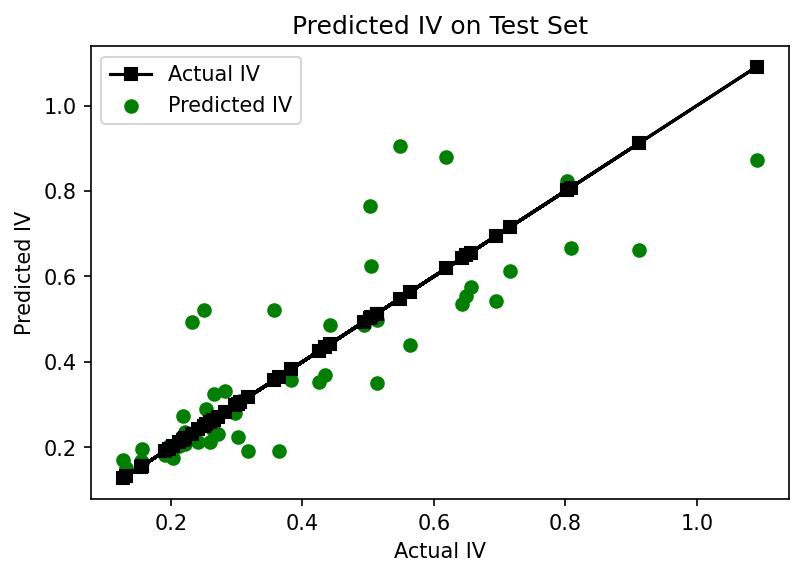

In [9]:
import matplotlib.pyplot as plt

Y = Ytest.tolist()

plt.figure(dpi=150)
plt.plot(Y, Y, marker = 's', c = 'black', label = 'Actual IV')
plt.scatter(Y, predictions, c = 'green', label = 'Predicted IV')
plt.xlabel('Actual IV')
plt.ylabel('Predicted IV')
plt.title('Predicted IV on Test Set')
plt.legend()
plt.show()